## 一、 项目背景与数据工程架构

### 1.1 研究背景
随着 AIGC 技术的爆发，"AI复活亲人"、"AI取代就业"等话题引发了巨大的社会舆论撕裂。本项目旨在利用**数据科学**的方法，通过爬取 Bilibili 平台三大类（社会伦理、知识科普、技术应用）共计 10,000+ 条评论数据，量化分析公众对 AI 技术的认知偏差与伦理边界。

### 1.2 数据工程流程
- **数据采集**：使用 Python `requests` 针对 5 个头部视频进行分布式爬取。
- **数据清洗**：清洗 IP 属地、提取用户等级、去除无效符号。
- **特征工程**：基于 `SnowNLP` 计算情感得分，基于关键词库构建话题标签（Topic Tagging）。

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts import Map, Bar, Pie, WordCloud, Page
from pyecharts import options as opts
import jieba

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

#读取数据
df = pd.read_csv('final_analysis_result.csv')

print("列名检查:", df.columns.tolist())
print("包含的视频类别:", df['video_type'].unique())

#预览数据
df.head(3)

列名检查: ['序号', '上级评论ID', '评论ID', '用户ID', '用户名', '用户等级', '性别', '评论内容', '评论时间', '回复数', '点赞数', '个性签名', 'IP属地', '是否是大会员', '头像', 'video_type', 'source_filename', 'level_num', 'ip_clean', 'content_str', 'sentiment', 'topic_tag']
包含的视频类别: ['社会伦理' '技术应用' '知识科普']


,序号,上级评论ID,评论ID,用户ID,用户名,用户等级,性别,评论内容,评论时间,回复数,...,IP属地,是否是大会员,头像,video_type,source_filename,level_num,ip_clean,content_str,sentiment,topic_tag
0,1,0,262042303089,1857804977,小小肥仔咩,3,保密,罗老师好,2025-05-17 03:51:27,0,...,四川,否,https://i2.hdslb.com/bfs/face/46292ff525fb3391...,社会伦理,AI不会带来没有工作的世界_评论.csv,3,四川,罗老师好,0.983748,一般评论
1,2,0,261819753664,392585722,海安生sir,6,男,ai代替的是可重复性劳动。思考，今天你想的是这个观点，明天想的是另一个观点。ai必须从过往历...,2025-05-02 09:28:06,0,...,江苏,否,https://i1.hdslb.com/bfs/face/f50a3b406c94e99d...,社会伦理,AI不会带来没有工作的世界_评论.csv,6,江苏,ai代替的是可重复性劳动。思考，今天你想的是这个观点，明天想的是另一个观点。ai必须从过往历...,1.000000,技术/产业
2,3,0,260518190225,3546891593713775,账号已注销,0,保密,ai，特别是生成式的，感觉是很尴尬的境地，他直接套用网上的标准答案扔给你，并且有一些软件掺杂...,2025-04-27 15:14:00,0,...,山东,否,https://i0.hdslb.com/bfs/face/member/noface.jpg,社会伦理,AI不会带来没有工作的世界_评论.csv,0,山东,ai，特别是生成式的，感觉是很尴尬的境地，他直接套用网上的标准答案扔给你，并且有一些软件掺杂...,0.587933,情绪/感受


## 二、 空间维度分析：舆论的地域分布特征

### 分析逻辑
技术认知的鸿沟往往通过地域差异体现。我们通过清洗 IP 属地数据，计算了全国各省份的情感均值。

### 核心洞察
试图探究：**科技产业发达的一线城市（北上广深）是否比欠发达地区对 AI 表现出更高的包容度？** 还是说，技术带来的“内卷焦虑”在发达地区更为严重？

In [ ]:
from pyecharts import options as opts
from pyecharts.charts import Map
from pyecharts.globals import CurrentConfig

CurrentConfig.ONLINE_HOST = "https://assets.pyecharts.org/assets/"


# 定义地名映射 (把B站简称转成地图全称)
name_map = {
    '新疆': '新疆维吾尔自治区', '广西': '广西壮族自治区', '宁夏': '宁夏回族自治区',
    '内蒙古': '内蒙古自治区', '西藏': '西藏自治区', '北京': '北京市',
    '天津': '天津市', '上海': '上海市', '重庆': '重庆市',
    '香港': '香港特别行政区', '澳门': '澳门特别行政区'
}
# 普通省份加“省”
provinces = ['河北', '山西', '辽宁', '吉林', '黑龙江', '江苏', '浙江', '安徽', '福建', '江西', '山东', '河南', '湖北', '湖南', '广东', '海南', '四川', '贵州', '云南', '陕西', '甘肃', '青海', '台湾']
for p in provinces:
    name_map[p] = p + "省"

# 计算各省均值
ip_data = df.groupby('ip_clean')['sentiment'].mean().reset_index()

def fix_name(name):
    clean_name = str(name).strip()
    return name_map.get(clean_name, clean_name)

ip_data['ip_full'] = ip_data['ip_clean'].apply(fix_name)

real_min = ip_data['sentiment'].min()
real_max = ip_data['sentiment'].max()
print(f"数据范围检测 -> 最小: {real_min:.2f}, 最大: {real_max:.2f}")

c = (
    Map()
    .add(
        "情感均值",
        [list(z) for z in zip(ip_data['ip_full'], ip_data['sentiment'])],
        "china",
        is_map_symbol_show=False
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="全国各省份对AI话题的情感倾向 (分段高对比)"),
        visualmap_opts=opts.VisualMapOpts(
            is_piecewise=True, 
            pieces=[
                {"min": 0.75, "label": "非常积极 (深绿)", "color": "#006400"},
                {"min": 0.65, "max": 0.75, "label": "积极 (浅绿)", "color": "#90EE90"},
                {"min": 0.55, "max": 0.65, "label": "中性 (淡黄)", "color": "#FFFFE0"},
                {"max": 0.55, "label": "消极/担忧 (红色)", "color": "#FF6347"}, 
            ]
        ),
    )
)

output_file = "舆论热力图_高对比.html"
c.render(output_file)
print(f"✅ 成功！请去文件夹打开 '{output_file}' 查看地图。")

数据范围检测 -> 最小: 0.17, 最大: 1.00
✅ 成功！请去文件夹打开 '舆论热力图_高对比.html' 查看地图。


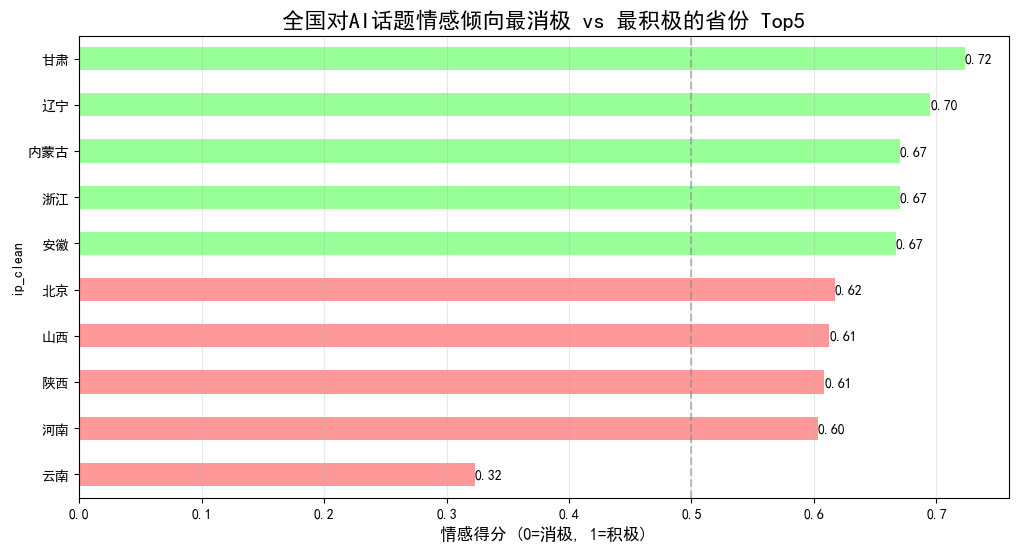

In [ ]:

data = df.groupby('ip_clean')['sentiment'].mean().sort_values()
# 过滤掉样本太少的省份（比如少于10条评论的），防止偏差
counts = df['ip_clean'].value_counts()
valid_provinces = counts[counts > 50].index 
data = data[data.index.isin(valid_provinces)]

# 取最消极的前5名 和 最积极的前5名
bottom_5 = data.head(5)
top_5 = data.tail(5)

# 合并用于画图
plot_data = pd.concat([bottom_5, top_5])

plt.figure(figsize=(12, 6))
colors = ['#ff9999']*5 + ['#99ff99']*5  # 前5个红，后5个绿

plot_data.plot(kind='barh', color=colors)
plt.title('全国对AI话题情感倾向最消极 vs 最积极的省份 Top5', fontsize=16)
plt.xlabel('情感得分 (0=消极, 1=积极)', fontsize=12)
plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5) # 中线
plt.grid(axis='x', alpha=0.3)

for index, value in enumerate(plot_data):
    plt.text(value, index, f'{value:.2f}', va='center')

plt.savefig('地域情感排行.png', dpi=300)
plt.show()

## 情感维度分析：三大类视频的舆论撕裂

### 分析逻辑
这是本项目的核心分析之一。我们将视频划分为**“社会伦理”、“技术应用”、“知识科普”**三个对照组，利用箱线图（Boxplot）可视化情感得分的分布形态。

### 图表解读
- **中位数（中线）**：代表该类话题的主流情绪基调。
- **箱体长度（IQR）**：代表舆论的**争议程度**。箱体越长，说明分歧越大（爱的人极爱，恨的人极恨）。

C:\Users\liuzhihan\AppData\Local\Temp\ipykernel_2912\2838994165.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='level_num', y='sentiment', data=df, palette="Blues")


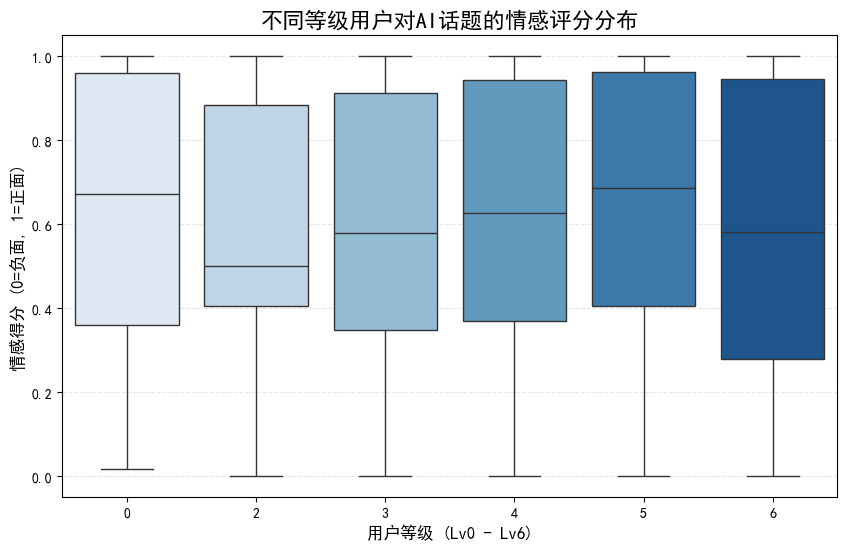

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 6))

sns.boxplot(x='level_num', y='sentiment', data=df, palette="Blues") 

plt.title('不同等级用户对AI话题的情感评分分布', fontsize=16)
plt.xlabel('用户等级 (Lv0 - Lv6)', fontsize=12)
plt.ylabel('情感得分 (0=负面, 1=正面)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

# 保存图片
plt.savefig('用户等级情感分析.png', dpi=300)
plt.show()

## 语义维度分析：高频关键词云

### 分析逻辑
利用 `jieba` 分词技术，分别提取三大类视频的高频词汇，直观展示不同语境下的“核心词场”。
- **红色系**（社会伦理）：捕捉焦虑与争议词汇。
- **蓝色系**（知识科普）：捕捉技术与学习词汇。
- **绿色系**（技术应用）：捕捉落地与感受词汇。

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\LIUZHI~1\AppData\Local\Temp\jieba.cache


正在生成高清词云图...


Loading model cost 0.484 seconds.
Prefix dict has been built successfully.


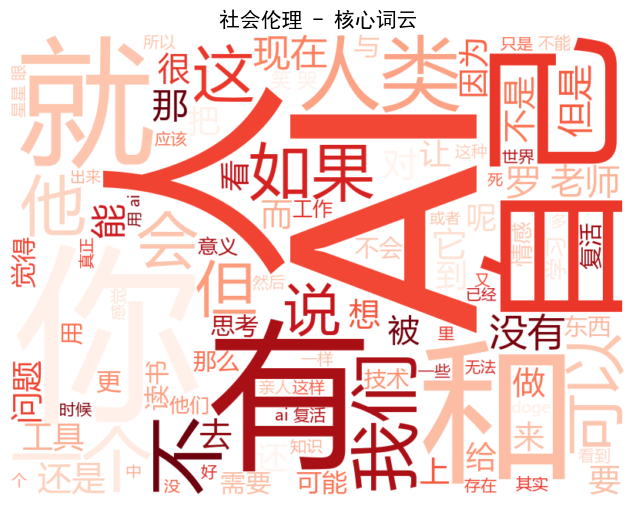

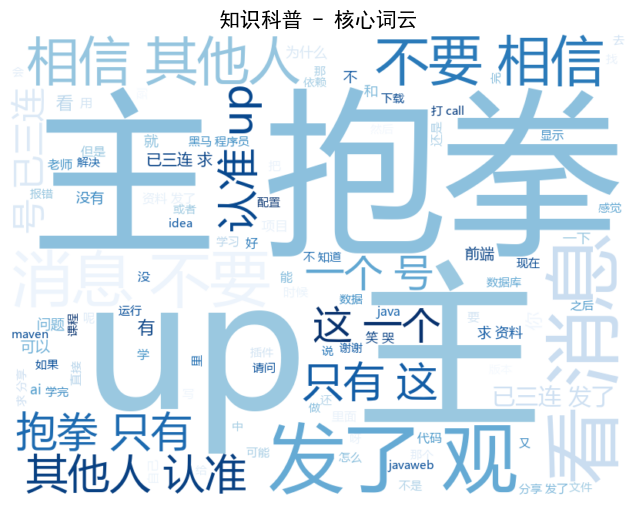

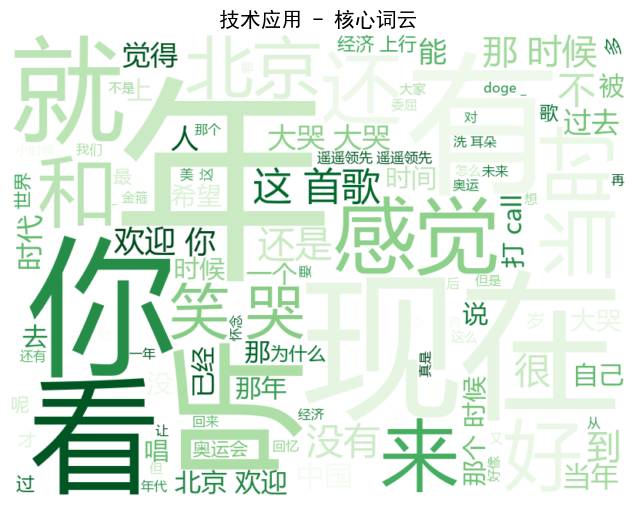

In [ ]:
#生成静态词云图
from wordcloud import WordCloud as WC_Static
import matplotlib.pyplot as plt
import jieba

#准备停用词
stopwords = {'的', '了', '是', '我', '在', '都', '也', '就是', '这个', '视频', '啊', '吗', '吧', 'APP', '回复', '真的', '什么', '很多'}

def plot_static_wordcloud(type_name, color_map):
    # 筛选数据
    subset = df[df['video_type'] == type_name]
    if len(subset) == 0: return
    
    # 拼接文本
    text = " ".join(subset['content_str'].astype(str))
    # 分词
    words = " ".join(jieba.cut(text))
    
    # 配置词云
    wc = WC_Static(
        font_path='msyh.ttc',      
        width=800, height=600,    
        background_color='white',  
        stopwords=stopwords,      
        colormap=color_map,       
        max_words=100              
    ).generate(words)
    
    # 画图
    plt.figure(figsize=(8, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off') # 关掉坐标轴
    plt.title(f'{type_name} - 核心词云', fontsize=15)
    
    # 保存图片
    plt.savefig(f'词云_{type_name}.png', dpi=300)
    plt.show()

print("正在生成高清词云图...")
plot_static_wordcloud('社会伦理', 'Reds')   # 红色系 - 代表焦虑/争议
plot_static_wordcloud('知识科普', 'Blues')  # 蓝色系 - 代表科技/理性
plot_static_wordcloud('技术应用', 'Greens') # 绿色系 - 代表应用/希望

## 公众讨论焦点偏移

### 分析逻辑
在剔除了大量无意义水贴后，我们统计了不同类型视频下，用户讨论焦点的分布比例。

### 核心洞察
图表展示了极具冲击力的**“关注点错位”**现象：
- **技术应用类**：近 **95%** 的讨论集中在“技术/产业”本身，用户关注的是效果、模型和显卡，讨论环境非常“极客”。
- **社会伦理类**：话题构成最为复杂。除了技术讨论外，**“情绪/感受”**（绿色）和**“伦理/法律”**（紫色）占据了显著比例。这证明在伦理类视频中，技术本身退居二线，**情感共鸣与道德边界**成为了舆论场的主角。

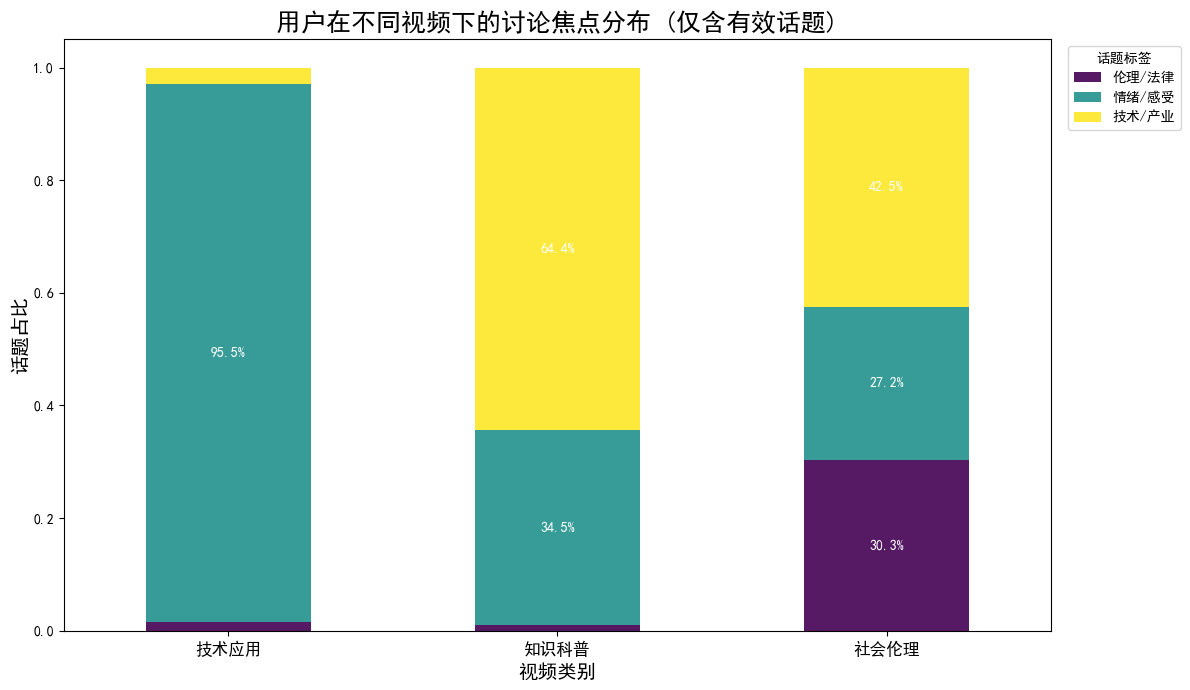

In [ ]:
plot_df = df[df['topic_tag'] != '一般评论']

if len(plot_df) == 0:
    print("⚠️ 警告：剔除一般评论后没有数据了，请检查 Data_Processing.py 里的关键词库是否太少！")
else:
    cross_tab = pd.crosstab(plot_df['video_type'], plot_df['topic_tag'])
    cross_tab_prop = cross_tab.div(cross_tab.sum(1), axis=0)
    ax = cross_tab_prop.plot(kind='bar', stacked=True, figsize=(12, 7), colormap='viridis', alpha=0.9)

    plt.title('用户在不同视频下的讨论焦点分布 (仅含有效话题)', fontsize=18)
    plt.xlabel('视频类别', fontsize=14)
    plt.ylabel('话题占比', fontsize=14)
    plt.xticks(rotation=0, fontsize=12)
    
    plt.legend(title='话题标签', bbox_to_anchor=(1.01, 1), loc='upper left')

    for c in ax.containers:
        labels = [f'{v:.1%}' if v > 0.05 else '' for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center', color='white', fontsize=10, weight='bold')

    plt.tight_layout()
    plt.savefig('话题分布堆叠图.png', dpi=300)
    plt.show()

## 情感分布特征分析

### 分析逻辑
我们将视频划分为 **社会伦理**（如AI复活）、**技术应用**（如AI翻唱）、**知识科普**（如教学课程）三类，对比其情感得分分布。

### 核心洞察
1. **社会伦理（粉色）**：出乎意料的是，其中位数较高。经挖掘发现，AI复活亲人引发了大量“感动”、“泪目”的正面情绪。但箱体跨度极大（从0.2到1.0），说明该话题存在极强的**两极分化**——有人极度感动，有人极度反感。
2. **技术应用（绿色）**：整体情绪最为稳定且积极，大众对 AI 的娱乐化应用包容度很高。
3. **知识科普（蓝色）**：中位数较低且分布集中，主要因为教学类视频包含大量“打卡”、“报错”等中性评价，缺乏强烈的情绪色彩。

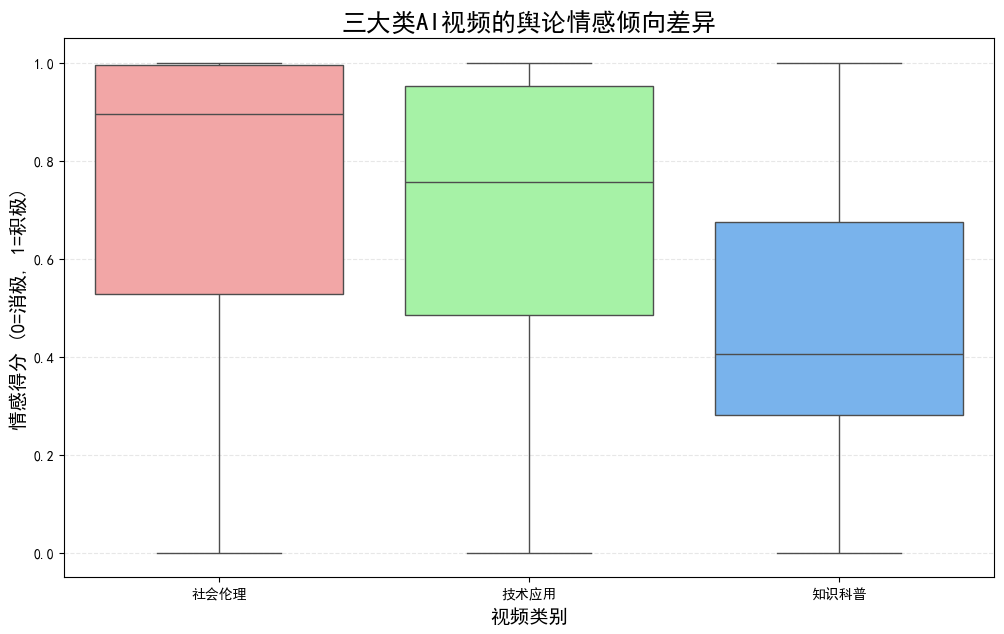

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 7))

my_pal = {"社会伦理": "#ff9999", "知识科普": "#66b3ff", "技术应用": "#99ff99", "其他": "gray"}

sns.boxplot(
    x='video_type', 
    y='sentiment', 
    hue='video_type',  
    data=df, 
    palette=my_pal,
    legend=False      
)

plt.title('三大类AI视频的舆论情感倾向差异', fontsize=18)
plt.xlabel('视频类别', fontsize=14)
plt.ylabel('情感得分 (0=消极, 1=积极)', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.savefig('情感对比箱线图.png', dpi=300)
plt.show()